 **必须安装scikit-image**
 
!pip install scikit-image scipy

# 有问题的部分
|位置|警告|当前方案|
|:-|:-|:-|
|modules.model.Transform.warp_coordinates|1.8.0post97中dygraph.grad()在有类似resnet的shortcut时梯度无法计算.<br>1.8.4post97缺少二阶梯度, create_graph=False可在1.8.4上运行但无法计算高阶导数|手动计算一阶导作为函数输出<br>附录部分有验证函数|
|modules.dense_motion:L61|矩阵求逆paddle.inverse仅在2.0提供|矩阵较小，手动求逆，也可切换至2.0|
|modules.dense_motion.DenseMotionNetwork.create_sparse_motions/create_deformed_source_image|执行loss.backward()报张量维度不可大于5|合并前两个维度,计算完成后再复原|
|modules.util.AntiAliasInterpolation2d|fluid.layers.interpolate(out, scale=self.scale, resample='NEAREST')缺少align_corners设置 <br>默认行为等同于align_corners=True, 论文代码中设置为false|使用resize_nearest代替即可|
|modules.dense_motion.DenseMotionNetwork.create_deformed_source_image|fluid.layers.grid_sampler无align_corners设置 <br>默认行为等同于align_corners=True, 论文代码中设置为false|解决方案已在2.0的commit中:[https://github.com/PaddlePaddle/Paddle/commit/79539cf198d5bba0fc77336399d81a307fd47e51](https://) 插值计算有点区别，影响不大(大概也许或许唔知..)，在进行测试的时候设置会成相同输出|

## 预训练模型兼容性

|预训练模型|对齐程度|当前生成效果|
|:-|:-|:-|
|Mgif|除优化器外参数对齐.<br><font color='red'>1.8.4post97下,同输入同随机变量同grid_sampler输出情况下,各部分loss及关键中间张量前六位有效数字一致.</font><br>grid_sampler暂时无等效方案.<br>,1.8.2/1.8.0/1.8.4/0.0.0(dev)均可运行,未进行个结点的测试|效果一致|
|Fashion|除优化器外参数对齐<br>默认配置fashion-256.yaml中没有设置sn: True(不开启谱正则化)<br><font color='red'>但其预训练模型权重中有谱正则化相关参数,故在配置文件中开启谱正则化sn: True</font>|效果一致|
|Vox|除优化器外参数对齐(无数据集)|效果一致|
|Bari|除优化器外参数对齐||

若要检查loss是否与pytorch一致,需令frames_dataset.py和modules文件夹内的部分文件第一行的TEST_MODE=True.检查TEST_MODE影响的部分输出,并在pytorch中相同位置做相似的操作之后即可比较
## 已实现的数据增强方法
- horizontal_flip
- time_flip
- jitter_param.hue

# 目录结构
```
├── dataset
│   ├── fashion		256x256 MP4文件(训练一次后转为帧序列)
│   └── moving-gif	256x256 GIF文件(训练一次后转为帧序列)
├── pre-trained		pytorch预训练模型
│   ├── bair
│   ├── fashion
│   ├── mgif
│   └── vox
├── scr			脚本文件
│   ├── config		配置文件
│   ├── data		没用到
│   └── modules		模块
└── test_file		测试用文件
    ├── fashion
    ├── mgif
    └── vox
```

# 数据集预处理

解压数据集，确保为如下路径
```
work
├── dataset
│   ├── fashion
│   │   ├── test	256x256 (MP4)
│   │   └── train	256x256 (MP4)
│   └── moving-gif
│       ├── test	(GIF)
│       └── train	(GIF)
```

In [ ]:
# 将一个目录及其子文件夹下所有.mp4文件保存为256*256px的图像序列, gif文件保存为原图像大小的图像序列(数据集已是256*256不需再次转换)
DATASET_PATH = '/home/aistudio/work/dataset'
from multiprocessing import  Pool
import pathlib
import numpy as np
import moviepy.editor as mp
import os
import imageio
def resize(path: pathlib.WindowsPath):
    if path.suffix == '.mp4':
        clip = mp.VideoFileClip(str(path))
        if str(clip.size) != [256, 256]:
            clip_resized = clip.resize(newsize=(256, 256))
        else:
            clip_resized = clip
        dir_path = path.with_suffix('')
        try:
            dir_path.mkdir()
        except FileExistsError:
            pass
        # 保存为图像序列
        clip_resized.write_images_sequence(str(dir_path)+'/%05d.png', logger=None)
        # clip_resized.write_videofile(str(path.with_name(path.stem+'_256'+path.suffix)), audio=True, logger=None)
    elif path.suffix == '.gif':
        dir_path = path.with_suffix('')
        try:
            dir_path.mkdir()
        except FileExistsError:
            pass
        img_array = imageio.mimread(str(path))
        for idx, i in enumerate(img_array):
            # print(i.shape)
            if len(i.shape) == 2:
                imageio.imwrite(str(path.with_suffix(''))+'/%05i.png'%idx, np.tile(i[..., np.newaxis], (1, 1, 3)))
            else:
                imageio.imwrite(str(path.with_suffix(''))+'/%05i.png'%idx, i[:, :, :3])
    else:
        return
    path.unlink()
pl = Pool(4)
procressList = [i for i in pathlib.Path(DATASET_PATH).glob('**/*.*')]
pl.map(resize, procressList)

In [ ]:
"""仅集群使用
Mgif保存为HDF5,集群训练时fashion也需存为HDF5
通过fp['image_name'][()]获取图像序列, shape:[frame_num, w, h, c]
"""
TRAINING_PATH = 'work/dataset/moving-gif/train' # 存放训练集gif的目录
import h5py, pathlib, imageio
import tqdm
import numpy as np
with h5py.File("mgif_train.hdf5","w") as fp
    for i in tqdm.tqdm(list(pathlib.Path(TRAINING_PATH).iterdir())):
            if i.is_file():
                fp.create_dataset(str(i.name), data=np.array(imageio.mimread(str(i))), dtype='uint8', compression="gzip", compression_opts=4)

# 模型转换结果（并非训练结果，当前只有mgif有PP的训练模型）

In [ ]:
cd ~/work/src/

/home/aistudio/work/src


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from imageio import mimread, imread, imwrite, imsave
import pathlib
def load_sequence_img(path:pathlib.PosixPath):
    if not isinstance(path, pathlib.PosixPath):
        path = pathlib.Path(path)
    # path = '/home/aistudio/work/dataset/fashion/train/A1W-zcVU1JS/'
    return [imread(i) for i in sorted(list(pathlib.Path(path).iterdir()))]

### Fashion
- 切换模型请修改fashion-256.yaml中的ckpt_model
- npz文件为pytorch预训练模型,pdparams为PP训练模型

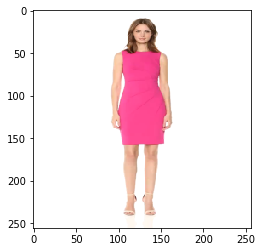

In [ ]:
# 抽取源图
# frame = mimread('/home/aistudio/work/dataset/fashion/train/A1W-zcVU1JS.mp4')[0]
frame = load_sequence_img('/home/aistudio/work/dataset/fashion/train/A1W-zcVU1JS')[0]
plt.imshow(frame)
imageio.imsave('/home/aistudio/work/test_file/fashion/test0.jpg', frame)

In [ ]:
"""展示源图及驱动视频"""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

source_image = imread('/home/aistudio/work/test_file/fashion/test0.jpg')
# driving_video = mimread('/home/aistudio/work/dataset/fashion/test/A14LlIk0zZS.mp4')
driving_video = load_sequence_img('/home/aistudio/work/dataset/fashion/test/A14LlIk0zZS')
pytorch_release = mimread('/home/aistudio/work/test_file/fashion/fashion_test0_A14LlIk0zZS.mp4')

#Resize image and video to 256x256
source_image = resize(source_image, (256, 256))[..., :3]
driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]
pytorch_release = [resize(frame, (256, 256))[..., :3] for frame in pytorch_release]

def display(source, driving, generated=None, pytorch=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in range(len(driving)):
        cols = [source]
        cols.append(driving[i])
        if generated is not None:
            cols.append(generated[i])
        if pytorch is not None:
            cols.append(pytorch[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani
    

HTML(display(source_image, driving_video).to_html5_video())

In [ ]:
"""生成帧"""
import paddle.fluid.dygraph as dygraph
import paddle.fluid as fluid
from demo import load_checkpoints
from demo import make_animation
from skimage import img_as_ubyte
with dygraph.guard(fluid.CUDAPlace(0)):
    generator, kp_detector = load_checkpoints(config_path='./config/fashion-256.yaml')
    predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=True)

Restore Pre-trained Generator
Restore Pre-trained KD


100%|██████████| 419/419 [00:10<00:00, 41.37it/s]


In [ ]:
"""显示结果, 倒数第二为PP生成，最后为pytorch生成"""
# imageio.mimsave('../generated_LYH_Scratch_3.mp4', [img_as_ubyte(frame) for frame in predictions])
#video can be downloaded from /content folder
HTML(display(source_image, driving_video, predictions, pytorch_release).to_html5_video())

2020-09-07 16:03:36,356-INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2020-09-07 16:03:36,357-INFO: MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '864x432', '-pix_fmt', 'rgba', '-r', '20.0', '-loglevel', 'quiet', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpnva54emc.m4v']


### Mgif
- 切换模型请修改mgif-256.yaml中的ckpt_model
- 有一个不完全的预训练模型,具体查看yaml文件,修改路径后依次执行下列cell即可
- npz文件为pytorch预训练模型,pdparams为PP训练模型

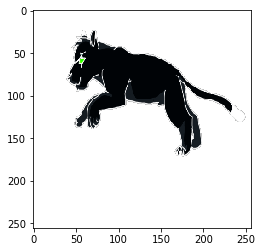

In [ ]:
"""从视频抽取帧保存为源图"""
# Mgif
%matplotlib inline
from imageio import mimread, imread
import matplotlib.pyplot as plt
import numpy as np
import imageio
#104
img = imread('/home/aistudio/work/dataset/moving-gif/train/00104/00000.png')
img = img[:, :, :]
plt.imshow(img)
plt.show()
imageio.imsave('/home/aistudio/work/test_file/mgif/test_moving-gif_2.png', img)

In [ ]:
"""展示源图及驱动视频"""
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

source_image = imageio.imread('/home/aistudio/work/test_file/mgif/test_moving-gif_2.png')
driving_video = load_sequence_img('/home/aistudio/work/dataset/moving-gif/train/00678')
# driving_video = imageio.mimread('/home/aistudio/work/dataset/moving-gif/train/00678.gif')
pytorch_release = imageio.mimread('/home/aistudio/work/test_file/mgif/pytorch_release.mp4')

#Resize image and video to 256x256
source_image = resize(source_image, (256, 256))[..., :3]
driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]
pytorch_release = [resize(frame, (256, 256))[..., :3] for frame in pytorch_release]

def display(source, driving, generated=None, pytorch=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in range(len(driving)):
        cols = [source]
        cols.append(driving[i])
        if generated is not None:
            cols.append(generated[i])
        if pytorch is not None:
            cols.append(pytorch[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani
    

HTML(display(source_image, driving_video).to_html5_video())

2020-09-07 16:04:30,642-INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2020-09-07 16:04:30,644-INFO: MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '576x432', '-pix_fmt', 'rgba', '-r', '20.0', '-loglevel', 'quiet', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpb172dgog.m4v']


In [ ]:
"""生成帧"""
import paddle.fluid.dygraph as dygraph
import paddle.fluid as fluid
from demo import load_checkpoints
from demo import make_animation
from skimage import img_as_ubyte
with dygraph.guard(fluid.CUDAPlace(0)):
    generator, kp_detector = load_checkpoints(config_path='./config/mgif-256.yaml')
    predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=True)

Restore Pre-trained Generator


 56%|█████▌    | 5/9 [00:00<00:00, 40.40it/s]

Restore Pre-trained KD


100%|██████████| 9/9 [00:00<00:00, 41.02it/s]

In [ ]:
"""显示结果, 倒数第二为PP生成，最后为pytorch生成"""
# imageio.mimsave('../generated_LYH_Scratch_3.mp4', [img_as_ubyte(frame) for frame in predictions])
#video can be downloaded from /content folder
HTML(display(source_image, driving_video, predictions, pytorch_release).to_html5_video())

2020-09-07 16:05:44,207-INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2020-09-07 16:05:44,209-INFO: MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '864x432', '-pix_fmt', 'rgba', '-r', '20.0', '-loglevel', 'quiet', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmprkb3jhm6.m4v']


### Vox
- 切换模型请修改vox-256.yaml中的ckpt_model
- npz文件为pytorch预训练模型,缺少数据集，此数据集未在PP上训练

In [ ]:
"""展示源图及驱动视频"""
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

source_image = imageio.imread('/home/aistudio/work/test_file/vox/test1.png')
driving_video = imageio.mimread('/home/aistudio/work/test_file/vox/10-backward.mp4')
py_release = imageio.mimread('/home/aistudio/work/test_file/vox/generated_pytorch.mp4')

#Resize image and video to 256x256
source_image = resize(source_image, (256, 256))[..., :3]
driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]
py_release = [resize(frame, (256, 256))[..., :3] for frame in py_release]    
def display(source, driving, generated=None, pytorch=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in range(len(driving)):
        cols = [source]
        cols.append(driving[i])
        if generated is not None:
            cols.append(generated[i])
        if pytorch is not None:
            cols.append(pytorch[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani
HTML(display(source_image, driving_video).to_html5_video())

2020-09-07 16:06:47,346-INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2020-09-07 16:06:47,348-INFO: MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '576x432', '-pix_fmt', 'rgba', '-r', '20.0', '-loglevel', 'quiet', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmp6fefyedu.m4v']


In [ ]:
"""生成帧"""
import paddle.fluid.dygraph as dygraph
import paddle.fluid as fluid
from demo import load_checkpoints
from demo import make_animation
from skimage import img_as_ubyte
with dygraph.guard(fluid.CUDAPlace(0)):
    generator, kp_detector = load_checkpoints(config_path='./config/vox-256.yaml')
    predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=True)

100%|██████████| 270/270 [00:06<00:00, 40.36it/s]


In [ ]:
"""显示结果, 倒数第二为PP生成，最后为pytorch生成"""
# imageio.mimsave('../generated_LYH_Scratch_3.mp4', [img_as_ubyte(frame) for frame in predictions])
#video can be downloaded from /content folder
HTML(display(source_image, driving_video, predictions, py_release).to_html5_video())

2020-09-07 16:07:13,393-INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2020-09-07 16:07:13,395-INFO: MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '864x432', '-pix_fmt', 'rgba', '-r', '20.0', '-loglevel', 'quiet', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpajhhshro.m4v']


# 训练部分
- 训练脚本兼容1.8.0/1.8.2/1.8.4/0.0.0(dev版), 推荐1.8.4post97
- notebook兼容1.8.0

## 脚本
```bash
$ cd ~/work/src/
$ python train_PP.py --config ./config/fashion-256.yaml
$ python train_PP.py --config ./config/bair-256.yaml(未添加数据集，暂时使用fashion数据集)
$ python train_PP.py --config ./config/mgif-256.yaml --preload(预读到内存加速)
```
具体设置修改配置文件
主要参数说明在taichi-256.yaml中

## Notebook

In [ ]:
cd ~/work/src/

/home/aistudio/work/src


Use predefined train-test split.
Load T:0.25184
A11-12 T:0.00003
A12-13 T:0.00008
A13-14 T:0.03371
Trans T:0.00017


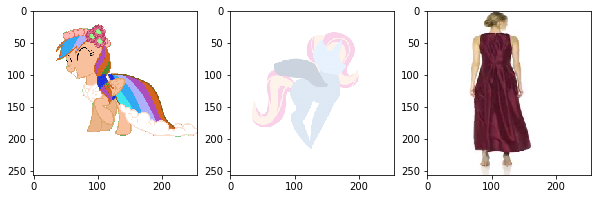

In [ ]:
"""测试数据集类"""
%matplotlib inline
# MGif 直读
# dataset/moving-gif_gif内有train和test子文件夹,存放gif文件
from frames_dataset import FramesDataset
dat = FramesDataset('/home/aistudio/work/dataset/moving-gif_gif',augmentation_params={'flip_param':{'horizontal_flip': True, 'time_flip': True},'jitter_param':{'hue': 0.5}}, process_time=True)
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 4))
plt.subplot(131)
plt.imshow(np.transpose(dat[4]['driving']*255, (1, 2, 0)).astype(np.uint8))
# MGif HDF5
from h5dat import FramesDataset
dat = FramesDataset('/home/aistudio/work/dataset/mgif_train.hdf5',augmentation_params={'flip_param':{'horizontal_flip': True, 'time_flip': True},'jitter_param':{'hue': 0.1}}, process_time=True)
plt.subplot(132)
plt.imshow(np.transpose(dat[263]['driving']*255, (1, 2, 0)).astype(np.uint8))
# Fashion HDF5
from h5dat import FramesDataset
dat = FramesDataset('/home/aistudio/work/dataset/fashion_train.hdf5',augmentation_params={'flip_param':{'horizontal_flip': True, 'time_flip': True},'jitter_param':{'hue': 0.1}}, process_time=True)
plt.subplot(133)
plt.imshow(np.transpose(dat[4]['driving']*255, (1, 2, 0)).astype(np.uint8))
plt.show()

In [ ]:
"""测试模型训练"""
from paddle import fluid
import paddle.fluid.dygraph as dygraph
import os, sys
import yaml
import numpy as np
from argparse import ArgumentParser
from time import gmtime, strftime
from shutil import copy

from modules.generator import OcclusionAwareGenerator
from modules.discriminator import MultiScaleDiscriminator
from modules.keypoint_detector import KPDetector
from train import train
plac = fluid.CUDAPlace(0)

if __name__ == "__main__":
    
    if sys.version_info[0] < 3:
        raise Exception("You must use Python 3 or higher. Recommended version is Python 3.7")

    parser = ArgumentParser()
    parser.add_argument("--config", required=True, help="path to config")
    parser.add_argument("--mode", default="train", choices=["train", "reconstruction", "animate"])
    parser.add_argument("--save_dir", default='/home/aistudio/train_ckpt', help="path to save")
    parser.add_argument("--device_ids", default="0", type=lambda x: list(map(int, x.split(','))),
                        help="Names of the devices comma separated.")
    parser.add_argument("--verbose", dest="verbose", action="store_true", help="Print model architecture")
    parser.add_argument("--preload", action='store_true', help="preload dataset to RAM")
    parser.set_defaults(verbose=False)

    # 测试时指定配置文件
    # mgif-256.yaml,fashion-256.yaml,bair-256.yaml可直接使用, 注意修改数据集路径:dataset_params.root_dir.
    # vox-256.yaml无对应数据集，目前只能将权重恢复进去。使用时需注释61及之后的行绕过数据集设置,再单独调执行下方第二个cell恢复权重
    # opt = parser.parse_args(args=['--config', './config/bair-256.yaml'])
    # opt = parser.parse_args(args=['--config', './config/fashion-256.yaml'])
    opt = parser.parse_args(args=['--config', './config/mgif-256.yaml', '--preload'])
    with open(opt.config) as f:
        config = yaml.load(f)

    save_dir = opt.save_dir
    with dygraph.guard(plac):
        generator = OcclusionAwareGenerator(**config['model_params']['generator_params'],
                                            **config['model_params']['common_params'])

    if opt.verbose:
        print(generator)
    with dygraph.guard(plac):
        discriminator = MultiScaleDiscriminator(**config['model_params']['discriminator_params'],
                                                **config['model_params']['common_params'])

    if opt.verbose:
        print(discriminator)
    with dygraph.guard(plac):
        kp_detector = KPDetector(**config['model_params']['kp_detector_params'],
                                **config['model_params']['common_params'])

    if opt.verbose:
        print(kp_detector)

    if 'hdf5' in config['dataset_params']['root_dir'].lower():
        print('HDF5 Dataset')
        from h5dat import FramesDataset as FramesDataset
    else:
        from frames_dataset import FramesDataset as FramesDataset
    dataset = FramesDataset(is_train=(opt.mode == 'train'), **config['dataset_params'])
    # 预读到内存
    if opt.preload:
        print('PreLoad Start')
        pre_list = list(range(len(dataset)))
        # HDF5 不可多进程读取
        if 'hdf5' in config['dataset_params']['root_dir'].lower():
            for i in pre_list:
                dataset.buffed[i] = dataset.preload(i)
                if i%100==0:
                    print('Loaded:%i'%i)
        else:
            import multiprocessing.pool as pool
            with pool.Pool(4) as pl:
                buf = pl.map(dataset.preload, pre_list)
            for idx, (i,v) in enumerate(zip(pre_list, buf)):
                dataset.buffed[i] = v.copy()
                buf[idx] = None
                if idx%100==0:
                    print('Loaded:%i'%idx)
        print('PreLoad End')
    else:
        print('Not PreLoad')

    if opt.mode == 'train':
        print("Training...")
        with dygraph.guard(plac):
            train(config, generator, discriminator, kp_detector, save_dir, dataset)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:39: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


HDF5 Dataset
Not PreLoad
Training...
start_epoch: 0


/home/aistudio/work/src/modules/util.py:275: RuntimeWarning: invalid value encountered in true_divide
  kernel *= np.exp(-(mgrid - mean) ** 2 / (2 * std ** 2))


Restore Pre-trained VGG19 from npz
Restore Generator from NPZ


  0%|          | 0/100 [00:00<?, ?it/s]

Restore KP from NPZ
Restore Discriminator from NPZ
Epoch:0	step: 0	Lr:0.0002000
perceptual:56.3015	gen_gan:0.9063	feature_matching:1.9415	equivariance_value:0.2424	equivariance_jacobian:0.9045	disc_gan:0.8505


In [ ]:
with dygraph.guard(plac):
    model_path = pathlib.Path(opt.save_dir)
    fluid.save_dygraph(generator.state_dict(), str(model_path.joinpath('G_param')))
    fluid.save_dygraph(discriminator.state_dict(), str(model_path.joinpath('D_param')))
    fluid.save_dygraph(kp_detector.state_dict(), str(model_path.joinpath('KP_param')))

In [ ]:
"""仅给vox-256.yaml恢复权重用的cell"""
with dygraph.guard(plac):
    ###### Restore Part ######
    ckpt_config = config['ckpt_model']
    if ckpt_config['generator'] is not None:
        if ckpt_config['generator'][-3:] == 'npz':
            G_param = np.load(ckpt_config['generator'], allow_pickle=True)['arr_0'].item()
            G_param_clean = [(i, G_param[i]) for i in G_param if 'num_batches_tracked' not in i]
            parameter_clean = generator.parameters()
            # The parameters in AntiAliasInterpolation2d is not in dict_set and should be ignore.
            del(parameter_clean[65])
            for v, b in zip(parameter_clean, G_param_clean):
                v.set_value(b[1])
            print('Restore Generator from NPZ')
        else:
            param, optim = fluid.load_dygraph(ckpt_config['generator'])
            generator.set_dict(param)
            if optim is not None:
                optimizer_generator.set_dict(optim)
            else:
                print('optimizer of G is not loaded')
            print('Restore Generator from Pdparams')
    if ckpt_config['kp'] is not None:
        if ckpt_config['kp'][-3:] == 'npz':
            KD_param = np.load(ckpt_config['kp'], allow_pickle=True)['arr_0'].item()
            KD_param_clean = [(i, KD_param[i]) for i in KD_param if 'num_batches_tracked' not in i]
            parameter_cleans = kp_detector.parameters()
            for v, b in zip(parameter_cleans, KD_param_clean):
                v.set_value(b[1])
            print('Restore KP from NPZ')
        else:
            param, optim = fluid.load_dygraph(ckpt_config['kp'])
            kp_detector.set_dict(param)
            if optim is not None:
                optimizer_kp_detector.set_dict(optim)
            else:
                print('optimizer of KP is not loaded')
            print('Restore KP from Pdparams')
    if ckpt_config['discriminator'] is not None:
        if ckpt_config['discriminator'][-3:] == 'npz':
            # 读取npz文件
            D_param = np.load(ckpt_config['discriminator'], allow_pickle=True)['arr_0'].item()
            if 'NULL Place' in ckpt_config['discriminator']:
                # 原本用于恢复Fashion，现已在fashion-256.yaml中添加sn:True故占位
                ## fashion-256.yaml配置文件中未使用谱正则化，但预训练模型有谱正则化的相关参数，故从npz中删除谱正则化相关量
                D_param_clean = [(i, D_param[i]) for i in D_param if 'num_batches_tracked' not in i and 'weight_v' not in i and 'weight_u' not in i]
                for idx in range(len(D_param_clean)//2):
                    if 'conv.bias' in D_param_clean[idx*2][0]:
                        D_param_clean[idx*2], D_param_clean[idx*2+1] = D_param_clean[idx*2+1], D_param_clean[idx*2]
                parameter_clean = discriminator.parameters()
                for v, b in zip(parameter_clean, D_param_clean):
                    v.set_value(b[1])
            else:
                D_param_clean = list(D_param.items())
                parameter_clean = discriminator.parameters()
                assert len(D_param_clean) == len(parameter_clean)
                ## 调换顺序
                ## PP中:        [conv.weight,   conv.bias,          weight_u, weight_v]
                ## pytorch中:   [conv.bias,     conv.weight_orig,   weight_u, weight_v]
                for idx in range(len(parameter_clean)):
                    if list(parameter_clean[idx].shape) == list(D_param_clean[idx][1].shape):
                        parameter_clean[idx].set_value(D_param_clean[idx][1])
                    elif parameter_clean[idx].name.split('.')[-1] == 'w_0' and D_param_clean[idx+1][0].split('.')[-1] == 'weight_orig':
                        parameter_clean[idx].set_value(D_param_clean[idx+1][1])
                    elif parameter_clean[idx].name.split('.')[-1] == 'b_0' and D_param_clean[idx-1][0].split('.')[-1] == 'bias':
                        parameter_clean[idx].set_value(D_param_clean[idx-1][1])
                    else:
                        print('Error', idx)
            print('Restore Discriminator from NPZ')
        else:
            param, optim = fluid.load_dygraph(ckpt_config['discriminator'])
            discriminator.set_dict(param)
            if optim is not None:
                optimizer_discriminator.set_dict(optim)
            else:
                print('optimizer of Discriminator is not loaded')
            print('Restore Discriminator from Pdparams')

Restore Generator from NPZ
Restore KP from NPZ
Restore Discriminator from NPZ


# 附录

**<font size=5>数据集性能</font>**<br>
- <font size=4>Mgif+预读 22:57</font>
![](https://ai-studio-static-online.cdn.bcebos.com/dbe32641c65c40fe8469492adb7558c2906cf405101544969d4d64caecca2045)
- <font size=4>Fashion存为npy 23:17</font>
![](https://ai-studio-static-online.cdn.bcebos.com/197ae228988f4ff8870bbc8477ccc00deef7060beb2742a0955fba9687dbd78f)
- <font size=4>Fashion存为图像序列23:23</font>
![](https://ai-studio-static-online.cdn.bcebos.com/474dabde46fb436a861b87e0b2abe7e28286f249445c4626b3e154c265ec5c42)
- <font size=4>Fashion mp4很慢</font>
- <font size=4>HDF不够快. 集群不能解压，只能用来当成中转载体</font>

|数据集|大小|
|:-:|:-:|
|moving-gif_npz|156M|
|moving-gif_npy_bk|3.9G|
|fashion_npy|36G|
|fashion_mp4|147M|    
|moving-gif|316M|
|fashion(图像序列)|1.8G|

## 模型转换
未包含优化器部分

In [ ]:
import torch
checkpoint = torch.load('/path/to/ckpt.pth.tar', map_location=torch.device('cpu'))

import numpy as np
V = [i.numpy() for i in checkpoint['discriminator'].values()]
newDict = dict(zip(checkpoint['discriminator'].keys(), V))
np.savez_compressed('/content/mgif/D_param', newDict)

V = [i.numpy() for i in checkpoint['generator'].values()]
newDict = dict(zip(checkpoint['generator'].keys(), V))
np.savez_compressed('/content/mgif/G_param', newDict)

V = [i.numpy() for i in checkpoint['kp_detector'].values()]
newDict = dict(zip(checkpoint['generator'].keys(), V))
np.savez_compressed('/content/mgif/KP_param', newDict)

## 一阶验证

### Pytorch
theta/control_points/control_params
为预设常量,shape如代码所示

In [ ]:
import torch
import numpy as np
from torch.autograd import grad
FT = lambda x: torch.FloatTensor(x)
def warp_coordinates(coordinates, tps=True):
  in_shape = coordinates.shape
  coordinates.requires_grad=True
  theta = FT(np.random.random((5, 2, 3)).astype(np.float32))
  np.save('theta', theta)
  theta = FT(np.load('theta.npy'))
  theta = theta.unsqueeze(1)
  parta = theta[:, :, :, :2]
  transformed = torch.matmul(theta[:, :, :, :2], coordinates.unsqueeze(-1)) + theta[:, :, :, 2:]
  transformed = transformed.squeeze(-1)

  if tps:
    control_points = FT(np.random.random([1, 5, 5, 2]).astype(np.float32)*3)
    np.save('control_points', control_points)
    control_points = FT(np.load('control_points.npy'))*3
    control_params = FT(np.random.random([5, 1, 25]).astype(np.float32)*4)
    np.save('control_params', control_params)
    control_params = FT(np.load('control_params.npy'))
    distances0 = coordinates.view(coordinates.shape[0], -1, 1, 2) - control_points.view(1, 1, -1, 2)
    distances1 = torch.abs(distances0)
    distances = torch.sum(distances1, -1)

    result = distances ** 2
    result1 = result * torch.log(distances + 1e-6)
    result2 = result1 * control_params
    result3 = result2.sum(dim=2).view(5, coordinates.shape[1], 1)
    transformed = transformed + result3
  return transformed
# a = FT(np.random.random((1, 65536, 2)).astype(np.float32)*2)
a = FT(np.load('/content/coordinates_in.npy'))*5
result = warp_coordinates(a, True)
a.requires_grad=True
dd0 = grad(result[..., 0].sum(), a, create_graph=True)[0]
dd1 = grad(result[..., 1].sum(), a, create_graph=True)[0]

### PP

In [ ]:
import paddle
import numpy as np
from paddle import fluid

def warp_coordinates(coordinates_in, tps=True, need_grad=True):
    coordinates_in.stop_gradient = False
    in_shape = coordinates_in.shape
    # theta = paddle.fluid.dygraph.to_variable(np.ones((5, 2, 3)).astype(np.float32))
    theta = paddle.fluid.dygraph.to_variable(np.load('theta.npy'))
    theta = fluid.layers.reshape(theta, (theta.shape[0], 1, theta.shape[1], theta.shape[2]))
    coordinates = fluid.layers.reshape(coordinates_in, (*coordinates_in.shape, 1))
    theta_parta = theta[:, :, :, :2]
    transformed = fluid.layers.matmul(*broadcast_v1(theta_parta, coordinates)) + theta[:, :, :, 2:]
    transformed = fluid.layers.squeeze(transformed, [-1])
    if tps:
        # control_points = paddle.fluid.dygraph.to_variable(np.ones([1, 5, 5, 2]).astype(np.float32)*3)
        # control_params = paddle.fluid.dygraph.to_variable(np.ones([5, 1, 25]).astype(np.float32)*4)
        control_points = paddle.fluid.dygraph.to_variable(np.load('control_points.npy'))*3
        control_params = paddle.fluid.dygraph.to_variable(np.load('control_params.npy'))
        _a = fluid.layers.reshape(coordinates, (coordinates.shape[0], -1, 1, 2))
        distances_0 = _a - fluid.layers.reshape(control_points, (1, 1, -1, 2))
        distances_1 = fluid.layers.abs(distances_0)
        distances = fluid.layers.reduce_mean(distances_1, -1)*fluid.dygraph.to_variable(np.array([distances_1.shape[-1]]).astype(np.float32))
        result0 = distances * distances
        result1 = result0 * fluid.layers.log(distances + 1e-6)
        result2 = result1 * control_params
        result3 = fluid.layers.reshape(fluid.layers.reduce_mean(result2, 2)*fluid.dygraph.to_variable(np.array([result2.shape[2]]).astype(np.float32)), (5, coordinates.shape[1], 1))
        transformed = transformed + result3
    if need_grad:
        _theta_part_a, _ = broadcast_v1(theta_parta, coordinates)
        _buf = _theta_part_a
        Dtransformed_0_Din = fluid.layers.unsqueeze(fluid.layers.reduce_mean(_buf[:, :, 0, :], 0), 0)
        Dtransformed_1_Din = fluid.layers.unsqueeze(fluid.layers.reduce_mean(_buf[:, :, 1, :], 0), 0)
        if tps:
            bool_mat = distances_0>fluid.dygraph.to_variable(np.array([0]).astype(np.float32))
            bool_mat = bool_mat.astype('float32')
            A = (fluid.dygraph.grad(result3, result1, create_graph=True)[0] * (fluid.dygraph.grad(fluid.layers.reduce_mean(result0)*fluid.dygraph.to_variable(np.prod(result0.shape).astype(np.float32).reshape(1)), distances, create_graph=True)[0] * fluid.layers.log(distances + 1e-6) + result0 * 1 / (distances + 1e-6)))
            A2 = fluid.layers.unsqueeze(A, [-1])
            A2 = fluid.layers.expand_as(A2, bool_mat)
            # print(A2.numpy()[0, 0, :5, :])
            A3 = A2 * (bool_mat*2 -1)
            A4 = fluid.layers.reduce_sum(A3, -2)
            A5 = fluid.layers.reshape(A4, in_shape)
            # print(Dtransformed_0_Din.numpy())
            return transformed, (Dtransformed_0_Din+A5, Dtransformed_1_Din+A5)
        else:
            return transformed, (Dtransformed_0_Din, Dtransformed_1_Din)
    return transformed
def broadcast_v1(x, y):
    """
    Broadcast before matmul
    """
    if len(x.shape) != len(y.shape):
        raise ValueError()
        # pdb.set_trace()
    *dim_x, _, _ = x.shape
    *dim_y, _, _ = y.shape
    max_shape = np.max(np.stack([dim_x, dim_y], axis=0), axis=0)
    if np.count_nonzero(max_shape%np.array(dim_x)) != 0 or np.count_nonzero(max_shape%np.array(dim_y)) != 0:
        raise ValueError()
    x_bc = fluid.layers.expand(x, (*((max_shape/np.array(dim_x)).astype(np.int32).tolist()), 1, 1)).astype('float32')
    y_bc = fluid.layers.expand(y, (*((max_shape/np.array(dim_y)).astype(np.int32).tolist()), 1, 1)).astype('float32')
    return x_bc, y_bc

with paddle.fluid.dygraph.guard(fluid.CPUPlace()):
    # a = paddle.fluid.dygraph.to_variable(np.ones((1, 65536, 2)).astype(np.float32)*2)
    a = paddle.fluid.dygraph.to_variable(np.load('coordinates_in.npy'))*5
    a.stop_gradient = False
    # grad_0对应dd0, grad_1对应dd1
    rs, (grad_0, trad_1) = warp_coordinates(a, True, True)